# Лабораторная №5 "Сети с обратными связями"

*Вариант* № 17

Красоткин Семён (М80-408Б-19)

## Цель работы

Исследование свойств сети Элмана, алгоритмов обучения, а также применение сети в задачах распознавания динамических образов.

## Основные этапы работы

1. Использовать сеть Элмана для распознавания динамических образов. Проверить качество распознавания.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [82]:
def plot_history(history, *metrics):
    for metric in metrics:
        print(f"{metric}: {history[metric][-1]:.4f}")
    figure = plt.figure(figsize=(5.25 * len(metrics), 3.75))
    for i, metric in enumerate(metrics, 1):
        ax = figure.add_subplot(1, len(metrics), i)
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title(metric)
        plt.plot(history[metric], '-')
    plt.show()

In [83]:
class ElmanLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(ElmanLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.w1 = nn.Parameter(torch.randn(in_features, out_features))
        self.w2 = nn.Parameter(torch.randn(out_features, out_features))
        self.b = nn.Parameter(torch.randn(out_features))
        self.prev = torch.zeros(out_features)
        
    def clear_memory(self):
        self.prev = torch.zeros(self.out_features)
        
    def forward(self, input):
        out = input @ self.w1 + self.b + self.prev @ self.w2
        out = torch.tanh(out)
        self.prev = out.clone().detach()
        return out

In [84]:
def signal(p1, p2, r1, r2, r3, a2, b2, h):
    t1 = np.arange(0, 1, h)
    t2 = np.arange(a2, b2, h)
    
    x1 = p1(t1)
    x2 = p2(t2)
    target1 = np.full(x1.shape, -1)
    target2 = np.full(x2.shape, 1)
    
    x = np.concatenate((np.tile(x1, r1), x2, np.tile(x1, r2), x2, np.tile(x1, r3), x2))
    target = np.concatenate((np.tile(target1, r1), target2, np.tile(target1, r2), target2, np.tile(target1, r3), target2))
    return x, target

In [85]:
def gen_dataset(data, target, window):
    return TensorDataset(
        torch.tensor(np.array([data[i:i+window] for i in range(len(data) - window + 1)]), dtype=torch.float32),
        torch.tensor(np.array([target[i:i+window] for i in range(len(target) - window + 1)]), dtype=torch.float32))

In [86]:
def p(k):
  return np.sin(4 * np.pi * k)

In [87]:
def g(k):
  return np.sin(2.5*k**2 - 5*k)

In [88]:
data, target = signal(p, g, 5, 5, 4, -1.14, 1.16, 0.01)

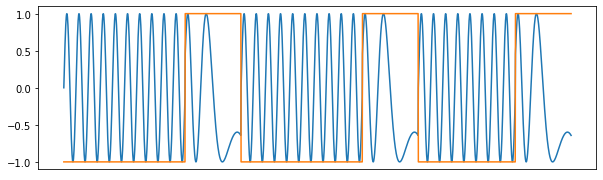

In [89]:
fig = plt.figure(figsize=(10, 3))
plt.xticks([])
plt.plot(data)
plt.plot(target)
plt.show()

In [90]:
windows = 8
hidden_layers = 32

In [91]:
dataset = gen_dataset(data, target, windows)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [92]:
elman = nn.Sequential(ElmanLayer(windows, hidden_layers), nn.Linear(hidden_layers, windows))

In [93]:
EPOCHS = 300
optim = torch.optim.Adam(elman.parameters(), lr=1e-4)
crit = nn.MSELoss()
history = defaultdict(list)
elman.train()
for epoch in tqdm(range(EPOCHS), desc='Epochs', ncols=70):
    losses = []
    epoch_correct = 0
    epoch_all = 0
    elman[0].clear_memory()
    for x_batch, y_batch in dataloader:
        out = elman(x_batch)
        pred = (out > 0).type(torch.long) * 2 - 1
        loss = crit(out, y_batch)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        epoch_correct += (pred == y_batch).sum().item()
        epoch_all += len(x_batch) * windows
    
    history['accuracy'].append(epoch_correct / epoch_all)
    history['loss'].append(np.mean(losses))


Epochs: 100%|███████████████████████| 300/300 [06:15<00:00,  1.25s/it]


loss: 0.6413
accuracy: 0.7876


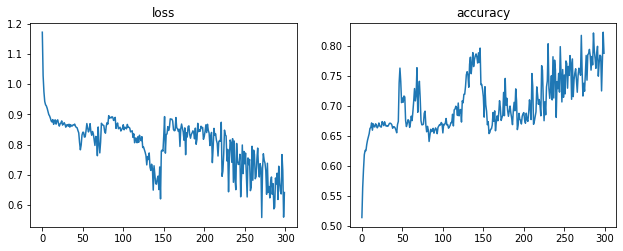

In [94]:
plot_history(history, 'loss', 'accuracy')

## Выводы
Ознакомился с сетью Элмана и реализовал её для распознавания динамического образа.